In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.models import Model, Sequential
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

from glob import glob

# Creating an Amazon captcha [Object detection] OCR

<h2>Table of contents:
<ul>
    <li>Getting and preparing the data</li>
    <li><a href='#labels_l'>Getting and preparing the labels for localization</a></li>
    <li><a href='#model_l'>Creating a Model for object localization</a></li>
    <li><a href='#data_c'>Preparing the data for classification</a></li>
    <li><a href='#model_c'>Creating a model for classification</a></li>
    <li><a href='#detection'>Final Object(letter) recognition</a></li>
</ul>
</h2>

## Getting and preparing the data:

<h3><font color='red'>Loading all images to numpy array</font></h3>

In [2]:
# get all .jpg files paths from the image folder
all_imgs = glob(f'images/*/*.jpg')
# sort them by CAPTCHA name
all_imgs = sorted(all_imgs, key=lambda x: x.split('/')[-1])  # sort by captcha name
print(f'{len(all_imgs)} images found')

150 images found


In [3]:
# before fitting images into the model, they need to be preprocessed
def prep_image(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    # get binary_inv threshold
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
    # since thresh has only 2 dimensions, reshape it and normalize it pixel values
    return thresh.reshape(70, 200, 1) / 255.0

In [4]:
# reading and loading all images to numpy array
original_images = []
for img in all_imgs:
    original_images.append(cv2.imread(img))
    
original_images = np.array(original_images)

<h4><font color='yellow'>Showing the effects of prep_image() function:</font></h4>

Original image: 		 Preprocessed image:


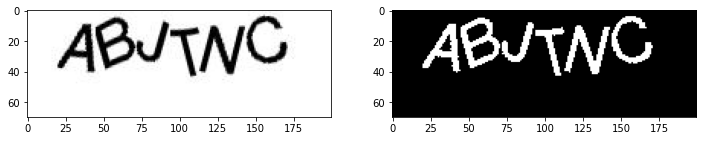

In [5]:
sample_img = cv2.imread(all_imgs[0])
sample_prep_img = prep_image(all_imgs[0])

fig = plt.figure(figsize=(12,12))
fig.add_subplot(1, 2, 1)
plt.imshow(sample_img)
fig.add_subplot(1, 2, 2)
plt.imshow(sample_prep_img, cmap='gray')
print('Original image: \t\t Preprocessed image:')

<h4><font color='yellow'>Processing all images:</font></h4>

In [6]:
data = []
# go through all images process them and append to data
for img in all_imgs:
    data.append(prep_image(img))
    
data = np.array(data) # convert to numpy 
print(f'Shape of the data: {data.shape}')

Shape of the data: (150, 70, 200, 1)


<h2><a name='labels_l'>Getting and preparing the labels:</a></h2>

<h3><font color='red'>Loading and preparing all labels:</font></h3>

In [7]:
# get all xml files
all_xml_paths = glob(f'images/*/*.xml')
print(f'{len(all_xml_paths)} XML files found')
# sort them by CAPTCHA name
all_xml_paths = sorted(all_xml_paths, key=lambda x: x.split('/')[-1])  # sort by captcha name

150 XML files found


In [8]:
# reading of XML files is easily done with BeautifulSoup
from bs4 import BeautifulSoup

def read_xml(path, x_div=200., y_div=70.):
    # reads single xml file created by image annotation
    with open(path) as f:
        soup = BeautifulSoup(f)
        letters = soup.select('object')
        # create list that will contain the xml data
        letters_info = []
        for let in letters: 
            # extracting data for each letter
            name = let.select_one('name').text
            # Divide coordinate points by image dimensions for model's sake(200 and 70 by default)
            x_min = int(let.select_one('xmin').text) / x_div
            y_min = int(let.select_one('ymin').text) / y_div
            x_max = int(let.select_one('xmax').text) / x_div
            y_max = int(let.select_one('ymax').text) / y_div
            letters_info.append([name, x_min, y_min, x_max, y_max])
        
        return letters_info

<h4><font color='yellow'>Showing the effects of read_xml() function:</font></h4>

In [9]:
from pprint import pprint

sample_label = read_xml(all_xml_paths[0])
print('Data extracted from XML file: ')
pprint(sample_label)

Data extracted from XML file: 
[['a', 0.09, 0.11428571428571428, 0.22, 0.6142857142857143],
 ['b', 0.215, 0.04285714285714286, 0.36, 0.7],
 ['j', 0.36, 0.05714285714285714, 0.47, 0.5857142857142857],
 ['t', 0.465, 0.08571428571428572, 0.565, 0.7714285714285715],
 ['n', 0.565, 0.1, 0.715, 0.7],
 ['c', 0.715, 0.04285714285714286, 0.865, 0.5285714285714286]]


<h4><font color='yellow'>Reading all xml files and extracing data:</font></h4>

In [10]:
labels = []

for path in all_xml_paths:
    # read xml file and convert it from list to dataframe
    read_df = pd.DataFrame(read_xml(path))
    # iloc to take only coordinates, convert to numpy array and flatten it 
    coordinates = pd.DataFrame(read_xml(path)).iloc[:, 1:].to_numpy().flatten()
    # make labels easier for model to train(divide by img width)
    labels.append(coordinates)
    
labels = np.array(labels)
print(f'Sample label: {labels[0]}')

Sample label: [0.09       0.11428571 0.22       0.61428571 0.215      0.04285714
 0.36       0.7        0.36       0.05714286 0.47       0.58571429
 0.465      0.08571429 0.565      0.77142857 0.565      0.1
 0.715      0.7        0.715      0.04285714 0.865      0.52857143]


<h4><font color='yellow'>Train/test split:</font></h4>

In [11]:
# shuffling the data
data = shuffle(data, random_state=27)
labels = shuffle(labels, random_state=27)
# 140 images for training and 10 for testing
x_train = data[:140]
y_train = labels[:140]
x_test = data[140:]
y_test = labels[140:]

<h2><a name='model_l'>Creating the object localization model:</a></h2>

In [12]:
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import Activation

In [13]:
# l2 regularization
reg = l2(0.0005)
model_ol = None

In [14]:
# inspired by Dr. Adrian Rosebrock and his StridedNet
model_ol = Sequential()
model_ol.add(Conv2D(16, (5, 5), strides=(2, 2), input_shape=(70, 200, 1), kernel_regularizer=reg))
model_ol.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg))
model_ol.add(Activation('relu'))

model_ol.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=reg))
model_ol.add(Dropout(0.25))

model_ol.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=reg))
model_ol.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu', kernel_regularizer=reg))
model_ol.add(Dropout(0.25))

model_ol.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=reg))

model_ol.add(Flatten())

model_ol.add(Dense(256, activation='relu'))
model_ol.add(Dense(24))

model_ol.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 33, 98, 16)        416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 98, 32)        4640      
_________________________________________________________________
activation (Activation)      (None, 33, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 49, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 17, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 49, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 25, 64)         3

<h4><font color='yellow'>Fitting the model:</font></h4>

In [15]:
# Training on 30 epochs using Adam with a slightly reduced learning rate
model_ol.compile(loss='mse', optimizer=Adam(lr=0.0008)) 

model_ol.fit(x_train, y_train, batch_size=8, epochs=30, verbose=1)

Epoch 1/30
18/18 [==============================] - 1s 30ms/step - loss: 0.1480
Epoch 2/30
18/18 [==============================] - 1s 30ms/step - loss: 0.1001
Epoch 3/30
18/18 [==============================] - 1s 30ms/step - loss: 0.0823
Epoch 4/30
18/18 [==============================] - 1s 29ms/step - loss: 0.0690
Epoch 5/30
18/18 [==============================] - 1s 30ms/step - loss: 0.0586
Epoch 6/30
18/18 [==============================] - 1s 30ms/step - loss: 0.0504
Epoch 7/30
18/18 [==============================] - 1s 29ms/step - loss: 0.0439
Epoch 8/30
18/18 [==============================] - 1s 29ms/step - loss: 0.0384
Epoch 9/30
18/18 [==============================] - 1s 29ms/step - loss: 0.0343
Epoch 10/30
18/18 [==============================] - 1s 30ms/step - loss: 0.0307
Epoch 11/30
18/18 [==============================] - 1s 30ms/step - loss: 0.0271
Epoch 12/30
18/18 [==============================] - 1s 29ms/step - loss: 0.0245
Epoch 13/30
18/18 [==================

<h4><font color='yellow'>Localization predictions:</font></h4>

In [16]:
preds = model_ol.predict(x_test)

<h4><font color='yellow'>Transforming predictions back to image's dimensions:</font></h4>

In [17]:
from math import ceil, floor

# Numbers must be rounded in order to draw rectangles
# Implementing a custom round function since int conversion only rounds DOWN no matter the fractional part
def my_round(num, thresh=0.2):
    """
    rounds the number up if its fractional point is above custom threshold, default is (0.2)
    """
    up = ceil(num)
    if up - num > thresh: 
        return up
    else:
        return floor(num)

In [18]:
def scale_predictions(preds):
    """
    takes in model's predictions and scales them back to image dimensions
    """
    trans_preds = []  # will store all transformed predictions
    for pred in preds:
        row = []
        # can be written as an list comprehension, however this one is easier to follow
        for n, p in enumerate(pred):
            # multiplying width coordinate by 200 and height coordinate by 70
            if n % 2 == 0:
                row.append(my_round(p*200))
            else:
                row.append(my_round(p*70))

        trans_preds.append(row)

    return trans_preds


In [19]:
trans_preds = scale_predictions(preds)
print(f'Example of an prediciton:\n {preds[0]}')
print('-'*70)
print(f'Example of transformed prediction:\n {trans_preds[0]}')

Example of an prediciton:
 [0.08045165 0.09831975 0.20425482 0.6182635  0.21320884 0.04043192
 0.3464246  0.58089036 0.34923774 0.03494112 0.46954098 0.59357804
 0.4594608  0.10696077 0.58529454 0.64226055 0.5760392  0.07135173
 0.7152148  0.60739356 0.69185895 0.0385158  0.82754594 0.5467609 ]
----------------------------------------------------------------------
Example of transformed prediction:
 [17, 6, 40, 44, 43, 2, 70, 41, 69, 3, 93, 42, 91, 8, 118, 44, 116, 4, 144, 43, 139, 3, 166, 39]


<h4><font color='yellow'>Plotting predicted bounding boxes:</font></h4>

In [20]:
def draw_rects(image, coords):
    """
    draws bounding boxes over the image
    param image: numpy array(image)
    param cords: bounding boxes coordinates(length of 24)
    """
    rect = image.copy()
    for i in range(int(len(coords)/4)):
        top_left = (int(coords[(i*4)+0]), int(coords[(i*4)+1]))
        bot_right = (int(coords[(i*4)+2]), int(coords[(i*4)+3]))
        rect = cv2.rectangle(rect, top_left, bot_right, (0, 255, 0), 1)

    return rect

<function matplotlib.pyplot.show(close=None, block=None)>

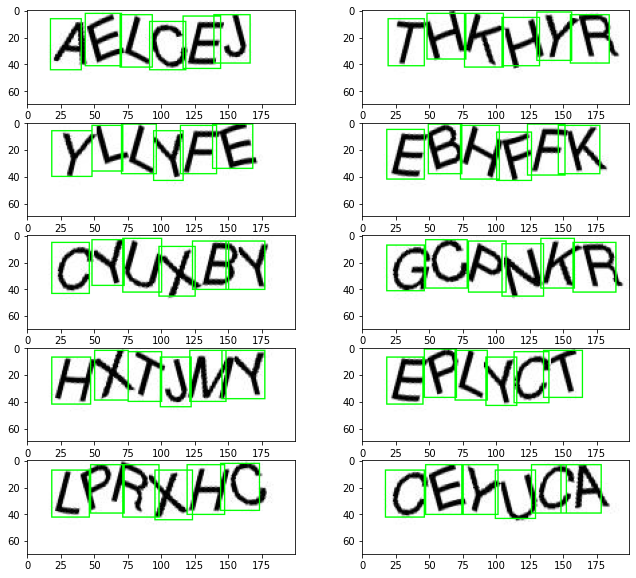

In [21]:
# shuffling original images in the same way, as predictions will be shown over them
test_imgs = shuffle(original_images, random_state=27)[140:]

w = 10
h = 10
fig = plt.figure(figsize=(11, 10))
columns = 2
rows = 5
# plotting 5x2 images
for n, (image, pred) in enumerate(zip(test_imgs, trans_preds)):
    # original image with bounding boxes drawn over them
    img = draw_rects(image, pred)
    fig.add_subplot(rows, columns, n+1)
    plt.imshow(img)
    
plt.show


In [22]:
# saving the model
model_ol.save('models/sdNet_0.0008ep30.h5')

### Model achieved decent accuracy considering there were only 140 images to train on, now let's use the same images to extract letters from them and create an classifier

<h2><a name='data_c'>Preparing the data for <b>Classification:</b></a></h2>

<h3><font color='red'>Extracting each letter from captcha:</font></h3>

In [23]:
letter_images = []  # all CAPTCHA letters as separate images
letter_names = []  # all letter names

# shuffle xml paths to match data
shuffled_xml_paths = shuffle(all_xml_paths, random_state=27)
# go through each image in data and through each path in xml paths 
for img, xml_path in zip(data, shuffled_xml_paths):
    xml_data = read_xml(xml_path, x_div=1, y_div=1)
    # go through each letter info inside xml file
    for info in xml_data:
        letter_names.append(info[0])
        xmin = int(info[1])
        ymin = int(info[2])
        xmax = int(info[3])
        ymax = int(info[4])
        # cropping the letter from captcha and resizing it to 50x50
        crop_img = cv2.resize(img[ymin:ymax, xmin:xmax, :], (50, 50))
        let_img = cv2.threshold(crop_img.copy(), 0.127, 0.255, cv2.THRESH_BINARY)[1]
        letter_images.append(let_img.reshape(50, 50, 1))


print(f'Amount of extracted letters:', len(letter_images))

Amount of extracted letters: 900


<h4><font color='yellow'>Example of a letter image:</font></h4>

Letter name [t]
(50, 50, 1)


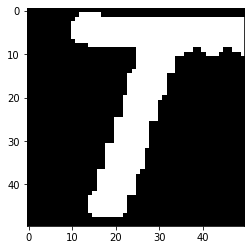

In [24]:
print(f'Letter name [{letter_names[0]}]')
plt.imshow(letter_images[0], cmap='gray')
print(letter_images[0].shape)

In [25]:
from sklearn.preprocessing import LabelBinarizer
# one-hot encoding the labels
lb = LabelBinarizer().fit(letter_names)

class_labels = lb.transform(letter_names).astype('float32')
class_data = np.array(letter_images)

# shuffle data and labels
class_labels = shuffle(class_labels, random_state=15)
class_data = shuffle(class_data, random_state=15)

print(f'Letter images shape: {class_data.shape}')
print(f'Label example: {class_labels[0]}')

Letter images shape: (900, 50, 50, 1)
Label example: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


<h4><font color='yellow'>Utilizing image augmentation:</font></h4>

In [253]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=25,
    rescale=0.1,
)
image_datagen = datagen.flow(class_data, class_labels, batch_size=16)

<h2><a name='model_c'>Creating the letter classification model:</a></h2>

In [256]:
def classification_model(nr_labels):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), input_shape=(IMAGE_SHAPE)))
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(nr_labels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0008), metrics=['acc']) 
    
    return model

<h3><font color='red'>Evaluating the model with K-fold cross validation:</font></h3>

In [34]:
IMAGE_SHAPE = class_data[0].shape
(unique, counts) = np.unique(class_labels.copy(), axis=0, return_counts=True)
nr_labels = len(unique)
print("Number of classes:", nr_labels)
print("Distribution of classes:", counts)

k = 4
num_val_samples = len(class_labels) // k  # fold size

all_val_scores = []

Number of classes: 18
Distribution of classes: [63 41 43 57 46 53 45 54 45 36 46 50 54 52 56 61 45 53]


In [35]:
model_test = None
for i in range(k):
    print(f'...Processing fold #{i}')
    # one evaluation fold
    val_data = class_data[i*num_val_samples: (i+1)*num_val_samples]
    val_labels = class_labels[i*num_val_samples: (i+1)*num_val_samples]
    # other three folds - training data
    train_data = np.concatenate([class_data[:i*num_val_samples], 
                                class_data[(i+1)*num_val_samples:]])
    train_labels = np.concatenate([class_labels[:i*num_val_samples], 
                                  class_labels[(i+1)*num_val_samples:]])
    
    # fitting the model
    model_test = classification_model(nr_labels)
    model_test.fit(train_data, train_labels, epochs=10, batch_size=15, verbose=1)
    # evaluating the model
    val_acc = model_test.evaluate(val_data, val_labels, verbose=1)
    all_val_scores.append(val_acc)

...Processing fold #0
Epoch 1/10
45/45 [==============================] - 0s 5ms/step - loss: 2.5654 - acc: 0.2430
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5259 - acc: 0.8370
Epoch 3/10
45/45 [==============================] - 0s 5ms/step - loss: 0.2359 - acc: 0.9289
Epoch 4/10
45/45 [==============================] - 0s 5ms/step - loss: 0.1624 - acc: 0.9615
Epoch 5/10
45/45 [==============================] - 0s 5ms/step - loss: 0.1000 - acc: 0.9807
Epoch 6/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0903 - acc: 0.9852
Epoch 7/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0918 - acc: 0.9807
Epoch 8/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0664 - acc: 0.9896
Epoch 9/10
45/45 [==============================] - 0s 5ms/step - loss: 0.0599 - acc: 0.9941
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.1323 - acc: 0.9822
...Processing fold #1
Epoch 1/10
45/45 [=========

###### <h4><font color='yellow'>Model obtained decent average accuracy</font></h4>

In [36]:
# getting average loss and accuracy
avg_loss = sum([i[0] for i in all_val_scores]) / k
avg_acc = sum([i[1] for i in all_val_scores]) /  k
print(f"Average validation accuracy is: {avg_acc} | loss is: {avg_loss}")

Average validation accuracy is: 0.9911111146211624 | loss is: 0.10632782615721226


###### <h4><font color='yellow'>However, if it were to be trained on original images, it wouldn't be accurate enough</font></h4>

In [257]:
model_c = None
model_c = classification_model(nr_labels)
model_c.summary()

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_346 (Conv2D)          (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_347 (Conv2D)          (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_348 (Conv2D)          (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_349 (Conv2D)          (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_350 (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_351 (Conv2D)          (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_60 (Flatten)         (None, 9216)            

###### <h4><font color='yellow'>Because of that, model is trained on augmented images:</font></h4>

In [258]:
# fitting on ImageDataGenerator || steps_per_epoch = total amount of images//batch_size(900//16)
model_c.fit(image_datagen, steps_per_epoch=56, epochs=20, verbose=1)

Epoch 1/20
56/56 [==============================] - 1s 18ms/step - loss: 2.8753 - acc: 0.0758
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 2.2440 - acc: 0.3032
Epoch 3/20
56/56 [==============================] - 1s 19ms/step - loss: 1.4014 - acc: 0.5543
Epoch 4/20
56/56 [==============================] - 1s 19ms/step - loss: 0.9629 - acc: 0.7036
Epoch 5/20
56/56 [==============================] - 1s 19ms/step - loss: 0.7969 - acc: 0.7489
Epoch 6/20
56/56 [==============================] - 1s 19ms/step - loss: 0.5804 - acc: 0.8213
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 0.4926 - acc: 0.8552
Epoch 8/20
56/56 [==============================] - 1s 19ms/step - loss: 0.5125 - acc: 0.8462
Epoch 9/20
56/56 [==============================] - 1s 19ms/step - loss: 0.3944 - acc: 0.8801
Epoch 10/20
56/56 [==============================] - 1s 18ms/step - loss: 0.3412 - acc: 0.8971
Epoch 11/20
56/56 [==============================] - 1s 18m

In [ ]:
# saving
model_c.save('models/classification_model.h5')

<h2><a name='detection'>Final letter object detection:</a></h2>

<h4><font color='yellow'>Step 1: Using the localization model to predict bounding boxes on a set of preprocessed captchas</font></h4>

In [53]:
# Back to those 10 images previously used for localization, now for detection
bbox_preds = model_ol.predict(x_test)
bbox_preds = scale_predictions(bbox_preds)

<h4><font color='yellow'>Step 2: Using the classification model to classify letters inside each bounding box</font></h4>

In [259]:
# although images are already loaded, some repetition is done for the sake of demonstartion
pred_letter_imgs = []
# extracting letters based on predicted bounding boxes for 
for (img, box_pred) in zip(x_test, bbox_preds):
    # for each letter
    for i in range(6):
        # getting coordinates
        x1 = box_pred[(i*4)+1]
        y1 = box_pred[(i*4)+3]
        x2 = box_pred[(i*4)]
        y2 = box_pred[(i*4)+2]
        # slicing the image and resizing it to 50x50
        try:
            crop_img = cv2.resize(img[x1:y1, x2:y2], (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        except:
            print(x1, y1, x2, y2)
        letter_img = cv2.threshold(crop_img.copy(), 0.127, 0.255, cv2.THRESH_BINARY)[1]
        
        # reshape to (50x50x1)
        pred_letter_imgs.append(letter_img.reshape(IMAGE_SHAPE))
    
# predict 
letter_preds = model_c.predict(np.array(pred_letter_imgs))
# transform back to characters and reshape
predicted_letters = lb.inverse_transform(letter_preds).reshape(-1, 6)
print('Predicted letters: ')
print(predicted_letters)

Predicted letters: 
[['a' 'e' 'l' 'c' 'e' 'j']
 ['t' 'h' 'k' 'h' 'n' 'r']
 ['y' 'l' 'l' 'y' 'f' 'e']
 ['e' 'b' 'h' 'f' 'f' 'k']
 ['c' 'y' 'u' 'x' 'b' 'n']
 ['g' 'c' 'p' 'n' 'k' 'r']
 ['h' 'x' 't' 'j' 'm' 'n']
 ['e' 'p' 'l' 'y' 'c' 't']
 ['u' 'p' 'r' 'x' 'h' 'p']
 ['c' 'e' 'y' 'u' 'e' 'a']]


# <h4><font color='yellow'>Step 3: Visualizing the Letter recognition</font></h4>

In [260]:
def draw_detection(image, coords, letters):
    """
    draws predicted letter and it's bounding box over image
    param image: numpy array(image)
    param cords: bounding boxes coordinates(length of 24)
    param letters: predicted letters
    """
    image_cpy = image.copy()
    for i in range(int(len(coords)/4)):
        top_left = (int(coords[(i*4)+0]), int(coords[(i*4)+1]))
        bot_right = (int(coords[(i*4)+2]), int(coords[(i*4)+3]))
        text_pos = (int(coords[(i*4)+0]),  int(coords[(i*4)+3]+9))
        
        # drawing bounding boxes and predicted class over image
        annotated_img = cv2.putText(image_cpy, letters[i].upper(), (text_pos), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.30, (255, 0, 0), 1)
        cv2.rectangle(annotated_img, top_left, bot_right, (0, 255, 0), 1)

    return annotated_img

<function matplotlib.pyplot.show(close=None, block=None)>

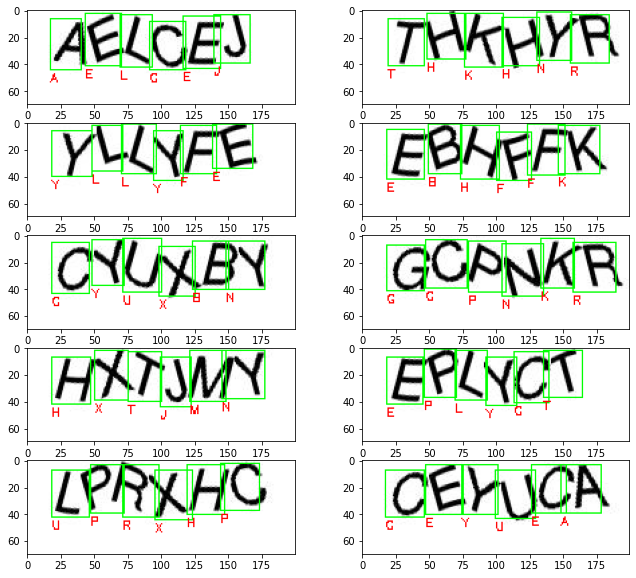

In [261]:
w = 10
h = 10
fig = plt.figure(figsize=(11, 10))
columns = 2
rows = 5
# plotting 5x2 images
for n, (image, coords, letters) in enumerate(zip(test_imgs, trans_preds, predicted_letters)):
    # original image with bounding boxes drawn over them
    img = draw_detection(image, coords, letters)
    fig.add_subplot(rows, columns, n+1)
    plt.imshow(img)
    
plt.show